In [430]:
import sys
sys.path.append("..")
from IPython.display import display

In [431]:
import numpy as np
import logging
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

## Visualization functions

In [432]:
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.cm as cm


norm = mpl.colors.Normalize(vmin=0.001, vmax=2.0)
cmap = cm.viridis_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def number_to_color(x):
    color = m.to_rgba(x)
    return "#%.2x%.2x%.2x%.2x" % (int(255*color[0]), 
                                  int(255*color[1]), 
                                  int(255*color[2]), 
                                  int(255*color[3]))


# Visualize the binary tree
def plot_jet_simple(jet,params=None, label=False):   
    content = jet["content"]
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow"}, 
                  edge_attr={"arrowsize": "0.5", "fontsize": "8.0"}, 
                  node_attr={"style": "filled"},
                  format="png")
#     print('Dot #1 =', dot)
    
    # Create a subgraph to plot all the leaves at the same level
    leaves = Digraph('leaves')
    leaves.attr(rank='same')
    
#     if label:
#         dot.graph_attr["label"] = label
    
    def _rec(jet, parent, node_id): 
        
        # Add a label with the "pT" of each node
        if label:
#             print("%.1f" %(jet["content"][node_id]))            
            node_label="%.1f" %(jet["content"][node_id])
        else:
            node_label=''""
        
        # Define the subgraph for each recursive call
        sub = Digraph( 
                      node_attr={"fixedsize": "true", 
                                 "label": str(node_label), 
                                 "height": "0.1", 
                                 "width": "0.1",
                                 "style": "filled"},
                      edge_attr={"arrowsize": "0.5",
                                 "fontsize": "8.0"})               

        size='0.6'
        node_color='lightblue' if  jet["tree"][node_id, 0] == -1  else 'wheat'
#         sub.node("%d" % node_id, width=size, height=size, shape="circle",
#                  color=number_to_color(node_color)) 

        # Add node
        sub.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 

        # Add leaves to the leaves subgraph 
        if jet["tree"][node_id, 0] == -1:
            leaves.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 

        # Add subgraph to main graph
        dot.subgraph(sub)

        ## ---------------------------------
        # Connect to parent
        if parent >= 0:  
            
            # Draw from root to leaves (1st entry is parent, 2nd entry is child)
            dot.edge("%d" % parent, "%d" % node_id, color=number_to_color(2),
         #label="h_%d" % (1+node_id)
                    )
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0])
            _rec(jet, node_id, jet["tree"][node_id, 1])
        
    # Run the recursive function    
    _rec(jet, -1, jet["root_id"]) 


    # Plot all the leaves at the same level
    dot.subgraph(leaves)
    
    return dot

In [4]:
# fd = open('trees/tree_graph.pkl', "rb")
fd = open('trees/tree_1.pkl', "rb")
X= pickle.load(fd,encoding='latin-1')
# X= pickle.load(fd,encoding='latin-1')
fd.close()

In [5]:
dot = plot_jet_simple(X,label=True)

In [6]:
dot2 = plot_jet_simple(X,label=True)

In [810]:
dot.attr(rankdir='TB', size='9,5')
dot2.attr(rankdir='BT', size='9,5')
# display(dot)
# display(dot2)

In [8]:
dot.source;

# kt, CA and anti-kt algorithms for the 1D exponential shower model

In [746]:
# Recursive function to get a list of the leaves

def _rec(jet, parent, node_id, outers_list):

    
    if jet["tree"][node_id, 0] == -1:
        outers.append(jet["content"][node_id])
    else:
        _rec(jet, node_id, jet["tree"][node_id, 0],outers_list)
        _rec(jet, node_id, jet["tree"][node_id, 1],outers_list)

    return outers_list

In [434]:
def dij(const_list):
    const_list = np.reshape(const_list,len(const_list))
#     print('const_list =', const_list)
    dijMin=np.inf
    for const in const_list:
        dij=np.sort(np.minimum(const**2,const_list**2)*(const-const_list)**2)
        print(dij)
        print('dij[1] =',dij[1])
        print('==='*4)
        #  We skip the 1st elements, as it corresponds to dii
        if dij[1]<dijMin:
            dijMin=dij[1]
    return dijMin

In [767]:
import itertools

def dijMinPair(const_list, var_dij_history, tree, jet_content, idx, alpha=None, Nconst=None, Nparent=None):
    
#     
    pairs = np.asarray(list(itertools.combinations(np.arange(len(const_list)),2)))
    
    # Get all dij at each level
#     dij_list = [(((const_list[pairs]**(2*alpha))[i])[0]*(const_list[pairs][i,0]-const_list[pairs][i,1])**2,i) for i in range(len(const_list[pairs]))]
    dij_list = [(np.sort((const_list[pairs]**(2*alpha))[i])[0]*(const_list[pairs][i,0]-const_list[pairs][i,1])**2,i) for i in range(len(const_list[pairs]))]
    
#     print('const_list[pairs]**(2*alpha) =',const_list[pairs]**(2*alpha))
#     print('Min const_list[pairs]**(2*alpha) =',[(np.sort((const_list[pairs]**(2*alpha))[i])[0],i) for i in range(len(const_list[pairs]))])
    
#     print('((const_list[pairs]**(2*alpha))[i])[0] =',(const_list[pairs]**(2*alpha)))
#     print([(((const_list[pairs]**(2*alpha))[i])[0],i) for i in range(len(const_list[pairs]))])
#     print('dij_list =',dij_list)
#     print('=+=+'*5)
    
    min_pair=sorted(dij_list,key=lambda x: x[0])[0][1]

    var_dij_history.append(dij_list[min_pair])

    # The rule to sum nodes in our model is the average
    new_list = np.append(np.delete(const_list,pairs[min_pair]),np.sum(const_list[pairs[min_pair]]))


    # The rule to sum nodes in our model is the average
    jet_content = np.concatenate((jet_content, [np.sum(const_list[pairs[min_pair]])]), axis=0)
#     print('jet_content =', jet_content)
    
    # Add a new key to the dictionary
    tree[Nconst+Nparent]=idx[pairs[min_pair]]
#     print('Tree = ', tree)
#     print('---'*5)

    # Delete the merged nodes
    idx = np.concatenate((np.delete(idx,pairs[min_pair]), [Nconst+Nparent]), axis=0)
#     idx.append(Nconst+Nparent)
    
    
          
    return new_list , var_dij_history, tree, idx,jet_content

In [670]:
const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = ktAntiktCA(jet_const,alpha=1)

Root node= (N constituents + N parent) = 6
const_list = [-42.75272369 -37.24727631  36.8556633   43.1443367 ]
CONST LIST SUM =  0.0
------------------------------------------------------------
jet_content = [-42.75272369 -37.24727631  36.8556633   43.1443367   80.        ]
Tree =  {4: array([2, 3])}
---------------
jet_content = [-42.75272369 -37.24727631  36.8556633   43.1443367   80.
 -80.        ]
Tree =  {4: array([2, 3]), 5: array([0, 1])}
---------------
jet_content = [-42.75272369 -37.24727631  36.8556633   43.1443367   80.
 -80.           0.        ]
Tree =  {4: array([2, 3]), 5: array([0, 1]), 6: array([4, 5])}
---------------


In [768]:
def ktAntiktCA(const_list, alpha=None):
    
    Nconst=len(const_list)
    root_node= 2*Nconst-2
#     print('Root node= (N constituents + N parent) =', root_node)
    
    idx = np.arange(Nconst)
    dij_hist=[]
    tree={}
    tree_list=[]
    const_list = np.reshape(const_list,len(const_list))
    jet_content=const_list
    
#     print('const_list =', const_list)
#     print('CONST LIST SUM = ',np.sum(const_list))
#     print('---'*20)
    
    for j in range(len(const_list)-1):
        const_list , dij_hist, tree, idx,jet_content = dijMinPair(const_list, dij_hist, tree, jet_content,idx, alpha=alpha,  Nconst=Nconst, Nparent=j)

        
    return const_list , dij_hist, tree, idx,jet_content, root_node, Nconst 

In [375]:
# const_list , dij_history, tree, idx,jet_content, root_node, Nconst = kt_algo(jet_const)

Root node= (N constituents + N parent) = 6
const_list = [-42.75272369 -37.24727631  36.8556633   43.1443367 ]
------------------------------------------------------------
jet_content = [-42.75272369 -37.24727631  36.8556633   43.1443367   80.        ]
Tree =  {4: array([2, 3])}
---------------
jet_content = [-42.75272369 -37.24727631  36.8556633   43.1443367   80.
 -80.        ]
Tree =  {4: array([2, 3]), 5: array([0, 1])}
---------------
jet_content = [-42.75272369 -37.24727631  36.8556633   43.1443367   80.
 -80.           0.        ]
Tree =  {4: array([2, 3]), 5: array([0, 1]), 6: array([4, 5])}
---------------


In [437]:
#------------------------------------------------------------------------------------------------------------- 
# This function call the recursive function to make the trees starting from the root
def _traverse(root, jet_nodes, tree_dic=None, root_idx=None, Nleaves=None, extra_info=False):#root should be a fj.PseudoJet
    tree=[]
    content=[]

#   sum_abs_charge=0
    _traverse_rec(root, -1, False, tree, content,jet_nodes, tree_dic= tree_dic, root_idx=root_idx , Nleaves=Nleaves, extra_info=extra_info) #We start from the root=jet 4-vector
    return tree, content

#------------------------------------------------------------------------------------------------------------- 


In [687]:
#------------------------------------------------------------------------------------------------------------- 
# Recursive function to access fastjet clustering history and make the tree. We will call this function below in _traverse.
def _traverse_rec(root, parent_id, is_left, tree, content, jet_nodes, tree_dic=None, root_idx=None,  Nleaves=None, extra_info=False): #root should be a fj.PseudoJet

    id=len(tree)//2
#     print('id=', id)
    if parent_id>=0:
        if is_left:
            tree[2 * parent_id] = id #We set the location of the lef child in the content array of the 4-vector stored in content[parent_id]. So the left child will be content[tree[2 * parent_id]]
        else:
            tree[2 * parent_id + 1] = id #We set the location of the right child in the content array of the 4-vector stored in content[parent_id]. So the right child will be content[tree[2 * parent_id+1]]
    #  This is correct because with each 4-vector we increase the content array by one element and the tree array by 2 elements. But then we take id=tree.size()//2, so the id increases by 1. The left and right children are added one after the other.

  #-------------------------------
  # We insert 2 new nodes to the vector that constitutes the tree. In the next iteration we will replace this 2 values with the location of the parent of the new nodes
    tree.append(-1)
    tree.append(-1)

    #     We fill the content vector with the values of the node 
    content.append(jet_nodes[root])
#   content.append(root.py())
#   content.append(root.pz())
#   content.append(root.e())

  #--------------------------------------
  # We move from the root down until we get to the leaves. We do this recursively

#     If not then its a leaf
    if root >=Nleaves:
        children=tree_dic[root]
#         print('Children = ', children)

        L_idx = children[0]
        R_idx  = children[1]

        #------------------------------   
        # Call the function recursively 

        _traverse_rec(L_idx, id, True, tree, content, jet_nodes, tree_dic, root_idx=L_idx, Nleaves=Nleaves, extra_info=extra_info) #pieces[0] is the left child
        _traverse_rec(R_idx, id, False, tree, content, jet_nodes, tree_dic, root_idx=R_idx, Nleaves=Nleaves, extra_info=extra_info) #pieces[1] is the right child


In [429]:
# const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = kt_algo(jet_const)

Root node= (N constituents + N parent) = 56
const_list = [-64.54608154 -24.87433052 -22.23275948 -21.52168083 -18.90468216
 -11.47380257  -8.89956093 -11.82156467   3.60985518   6.76969576
  11.69974136  13.45833969  16.01733017  23.03474617  22.31666756
  26.31586266  26.54963493  28.72600746  30.18586349  33.22929001
  40.47254181  42.95456696  45.28478241  33.57748795  37.36617661
  44.95471191  50.86771011  60.75399399  82.00302887]
CONST LIST SUM =  495.87357234954834
------------------------------------------------------------
jet_content = [-64.54608154 -24.87433052 -22.23275948 -21.52168083 -18.90468216
 -11.47380257  -8.89956093 -11.82156467   3.60985518   6.76969576
  11.69974136  13.45833969  16.01733017  23.03474617  22.31666756
  26.31586266  26.54963493  28.72600746  30.18586349  33.22929001
  40.47254181  42.95456696  45.28478241  33.57748795  37.36617661
  44.95471191  50.86771011  60.75399399  82.00302887 -11.64768362]
Tree =  {29: array([5, 7])}
---------------
jet_co

In [439]:
# #------------------------------------------------------------------------
# Create a dictionary with all the jet tree info (topology, constituents features: eta, phi, pT, E, muon label)
# Keep only the leading jet
def make_dictionary(tree, content, mass=None, pt=None, charge=None, abs_charge=None, muon=None):
    jet = {}

    jet["root_id"] = 0
    jet["tree"] = tree[0]  # Labels for the jet constituents in the tree
    #             jet["content"] = np.reshape(content[i],(-1,4,1)) #Where content[i][0] is the jet 4-momentum, and the other entries are the jets constituents 4 momentum. Use this format if using TensorFlow
    jet["content"] = np.reshape(content[0], (-1, 1))  # Use this format if using Pytorch
    # jet["mass"] = mass
    # jet["pt"] = pt
    # jet["energy"] = content[0][0, 3]
    #
    px = content[0][0]  # The jet is the first entry of content. And then we have (px,py,pz,E)
    # py = content[0][0, 1]
    # pz = content[0][0, 2]
    # p = (content[0][0, 0:3] ** 2).sum() ** 0.5
    #         jet["Calc energy"]=(p**2+mass[i]**2)**0.5
    # eta = 0.5 * (np.log(p + pz) - np.log(p - pz))  # pseudorapidity eta
    # phi = np.arctan2(py, px)
    #
    # jet["eta"] = eta
    # jet["phi"] = phi
    #


    return jet

In [781]:
out_dir='trees/'
def reshape_data(in_tree, in_content, algo='kt' ):
    

    tree = np.asarray([in_tree])
    tree = np.asarray([np.asarray(e).reshape(-1, 2) for e in tree])
    content = np.asarray([in_content])
    content = np.asarray([np.asarray(e).reshape(-1, 1) for e in content])

#     print('Tree = ', tree)
#     print('Content = ', content)
#     print('---'*10)

    jet = make_dictionary(tree, content)
#     print('Jet dictionary =', jet)
#     print('===' * 10)


    # SAVE OUTPUT FILE
    out_filename = out_dir+ str(algo)+'.pkl'
    print('out_filename=', out_filename)
    with open(out_filename, "wb") as f: pickle.dump(jet, f, protocol=2)

In [782]:
def recluster(input_jet, alpha=None):

    fd = open('trees/'+str(input_jet)+'.pkl', "rb")
    jet_truth= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
#     print('jet_truth =', jet_truth)
    
#     print('jet_truth =', jet_truth["root_id"])

    
    # Recursive function to get a list of the leaves

    def _rec(jet, parent, node_id, outers_list):


        if jet["tree"][node_id, 0] == -1:
            outers.append(jet["content"][node_id])
        else:
            _rec(jet, node_id, jet["tree"][node_id, 0],outers_list)
            _rec(jet, node_id, jet["tree"][node_id, 1],outers_list)

        return outers_list
    
    
    outers=[]
    jet_const=np.asarray( _rec(jet_truth, -1, jet_truth["root_id"],outers))
#     print(_rec(jet_truth, -1, jet_truth["root_id"],outers))
#     print('jet_const =',jet_const)
    
    const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = ktAntiktCA(jet_const, alpha=alpha)
    
    tree, content = _traverse(root_node, jet_content, tree_dic=raw_tree, root_idx=None, Nleaves=Nconst, extra_info=False)
    
    if alpha==-1:
        cluster_algo='antikt_'
    elif alpha==1:
        cluster_algo='kt_'
    elif alpha==0:
        cluster_algo='CA_'
    else:
        cluster_algo='New algo_'
    
    reshape_data(tree, content , algo=str(cluster_algo)+str(input_jet)+'_'+str(alpha))
    

In [818]:
def visualize(input_jet, alpha1=None, alpha2=None):

    
    if alpha1=='truth':
        cluster_algo1=''
        algo1=str(cluster_algo1)+str(input_jet)
    else:
        
        if alpha1==-1:
            cluster_algo1='antikt_'
        elif alpha1==1:
            cluster_algo1='kt_'
        elif alpha1==0:
            cluster_algo1='CA_'  
        else:
            cluster_algo1='New algo_'
            
        algo1=str(cluster_algo1)+str(input_jet)+'_'+str(alpha1)

        
        
    if alpha2=='truth':
        cluster_algo2=''
        algo2=str(cluster_algo2)+str(input_jet)
    else:
        
        if alpha2==-1:
            cluster_algo2='antikt_'
        elif alpha2==1:
            cluster_algo2='kt_'
        elif alpha2==0:
            cluster_algo2='CA_'  
        else:
            cluster_algo2='New algo_'
            
        algo2=str(cluster_algo2)+str(input_jet)+'_'+str(alpha2)
        
#     if alpha2==-1:
#         cluster_algo2='antikt_'
#     elif alpha2==1:
#         cluster_algo2='kt_'
#     elif alpha2==0:
#         cluster_algo2='CA_'  
#     elif alpha2=='truth':
#         cluster_algo2=''
#         alpha2=''
#     else:
#         cluster_algo2='New algo_'
    
    
#     algo2=str(cluster_algo2)+str(input_jet)+'_'+str(alpha2)

    
    fd = open('trees/'+algo1+'.pkl', "rb")
    X_1= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
    
    fd = open('trees/'+algo2+'.pkl', "rb")
    X_2= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
    dot = plot_jet_simple(X_1,label=True)
    dot2 = plot_jet_simple(X_2,label=True)
    
    dot.attr(rankdir='TB', size='9,5')
    dot2.attr(rankdir='BT', size='9,5')
    display(dot)
    display(dot2)

In [820]:
# input_jet='tree_4_truth'
input_jet='tree_6_truth'

### kt (bottom) vs truth (top) trees

out_filename= trees/kt_tree_6_truth_1.pkl


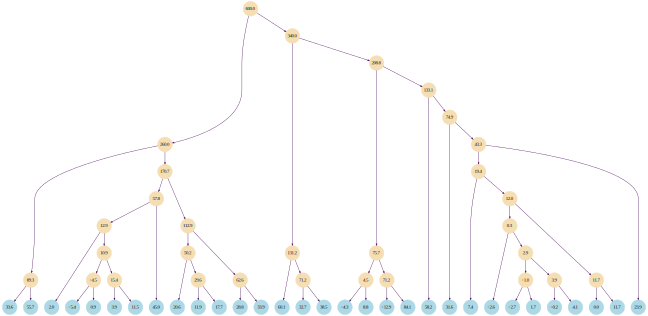

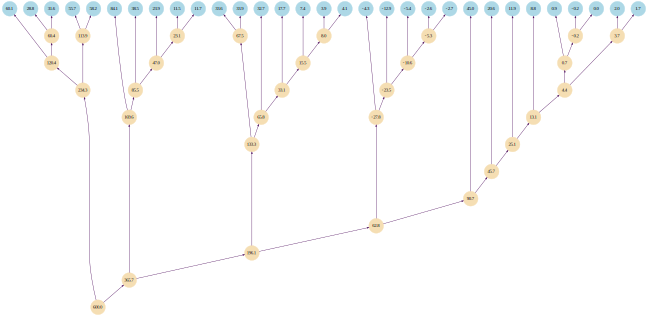

In [821]:

in_alpha=1
recluster(input_jet, alpha=in_alpha)

visualize(input_jet, alpha1='truth', alpha2=in_alpha)

### anti-kt (bottom) vs truth (top) trees

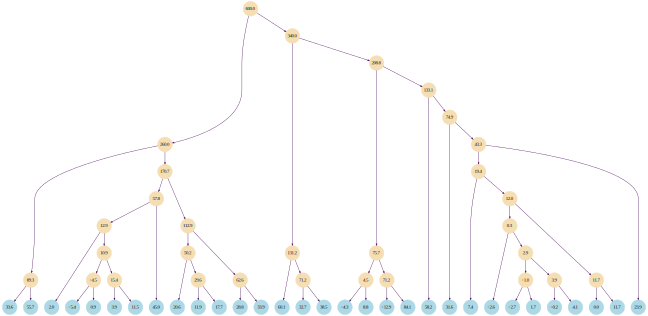

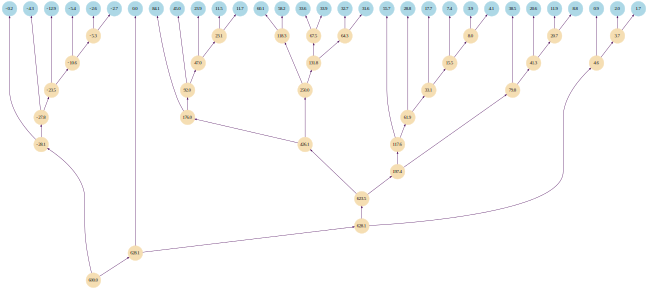

In [815]:
in_alpha1=-1
# recluster(input_jet, alpha=in_alpha1)


visualize(input_jet, alpha1='truth', alpha2=in_alpha1)

### CA (bottom) vs truth (top) trees

out_filename= trees/CA_tree_6_truth_0.pkl


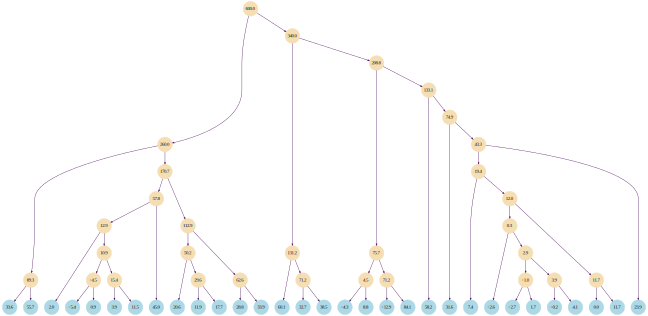

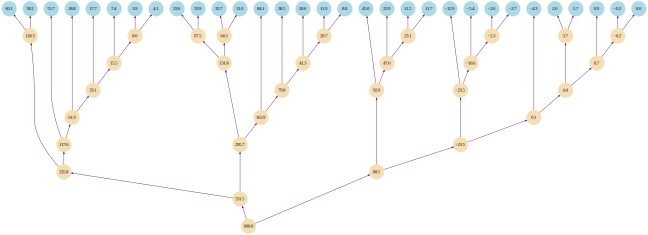

In [808]:
in_alpha=0
recluster(input_jet, alpha=in_alpha)

visualize(input_jet, alpha1='truth', alpha2=in_alpha)

### anti-kt (top) vs kt (bottom) trees

out_filename= trees/antikt_tree_6_truth_-1.pkl
out_filename= trees/kt_tree_6_truth_1.pkl


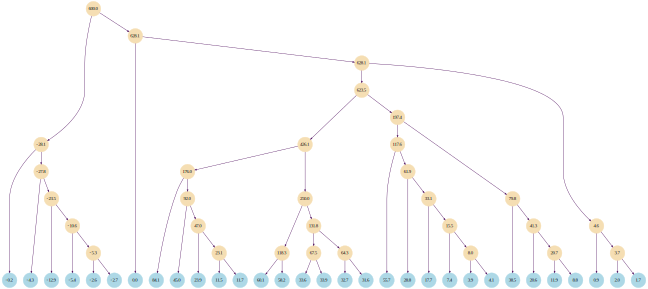

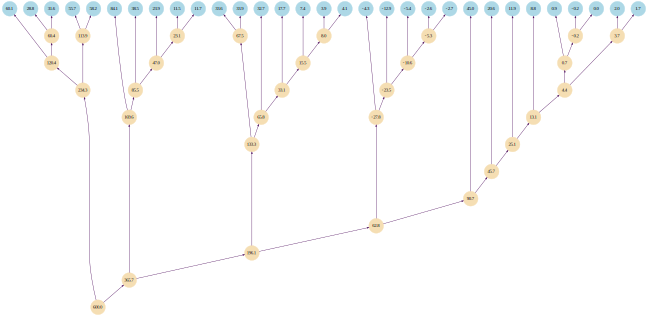

In [822]:
in_alpha1=-1
in_alpha2=1
recluster(input_jet, alpha=in_alpha1)
recluster(input_jet, alpha=in_alpha2)

visualize(input_jet, alpha1=in_alpha1, alpha2=in_alpha2)